In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import numpy as np
from core import stagger_FD_coeff as sfci
from core.utils import cholesky_solver
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler
from core.QUBO_solvers import IterSampleSolver
from collections import ChainMap
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from functools import wraps
pi = np.pi

In [43]:
def call_back(x_mid, obj_mid):
    global it_num
    qa_res_dict[f"iter_{it_num}"] = x_mid
    it_num += 1
    obj_list.append(obj_mid)
    
def solve_coeff_QA():

    # Using the real Quantum Annealing Hardware Dwave System!
    # You should sign up a count and get your API.
    # sampler = DWaveSampler(
    #     token="YOUR API TOKEN",
    #     solver="Advantage_system6.4",
    #     region="na-west-1",
    # )  #

    # Using your computer to simulate the quantum annealing.
    sampler = SimulatedAnnealingSampler()  # for test

    qa_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, freq_max, L=20)
        sis = IterSampleSolver(
            sampler=sampler,
            x0=np.ones(M)*1e-2,  # initial vector of Delta a
            num_sample=1000,  # for real hardware device using 2000
            R=10,
            fixed_point=1,
            maxiter=3,  # max iteration in small iteration
            code_method="pn",
            resultMod="lowest_energy",
        )
        start = time.perf_counter()
        qa_a0_dict[f"QA M={M}"], qa_a0_dict[f"Iter M={M}"] = linear_sys.solve(
            M=M,
            coeff_vec=np.ones([M]).reshape(-1, 1),
            alpha=1.0,
            alpha_decay=0.1,
            beta=1.0,
            epsilon=1e-10,
            max_iter_num=max_iter_num,
            mode_of_construct="direct",
            solver=sis.solve,
            return_iter_num=True,
            call_back=call_back,
        )
        end = time.perf_counter()
        qa_time.append(end - start)
    return qa_a0_dict

In [44]:
v = 4500
h = 10
tao = 0.001
freq_max_set = [190]
M_set = [10]
max_iter_num = 50
qa_time = []
qa_res_dict = {}
it_num = 1
obj_list = []
qa_a0_dict = solve_coeff_QA()
# result_dict = dict(ChainMap(qa_a0_dict, wang_a0_dict, tra_a0_dict))

/Volumes/Samsung_T5/My_Research/2_My_Articles/Quantum annealing Seismic forward modeling operator/JGR_MLC论文修改意见/code_for_the_paper/Solution_of_Forward_Operator_v2/core/QUBO_solvers.py:194: UserWarning: 'postprocess' indicates whether to optimize the result after sampler finish its work. Default method is 'SteepestDescentSolver'.
  warnings.warn(
/Volumes/Samsung_T5/My_Research/2_My_Articles/Quantum annealing Seismic forward modeling operator/JGR_MLC论文修改意见/code_for_the_paper/Solution_of_Forward_Operator_v2/core/QUBO_solvers.py:654: UserWarning: 'codingMod' indicates the way bit string to represent a number! It contain three mod, 'p', 'n', 'pn' If not specified, the default Settings will be used
  warnings.warn(


Current object function value is 3367.7366854226834


~~~~~~~~ Start 1 iteration ~~~~~~~~
Current coeff_vec is:
[[ 2.25036156 -0.46477915  0.82021073  0.61119139  0.02301481  1.19628478
  -0.24908906  1.19413484 -0.00560961  0.68002359]]
Current object function value is 311.7553865685728


~~~~~~~~ Start 2 iteration ~~~~~~~~
Current coeff_vec is:
[[ 1.37658359 -0.05426067  0.17316599  0.37885434 -0.01973433  0.58935029
  -0.07226734  0.56651849  0.02219582  0.31160883]]
Current object function value is 17.97341826577546


~~~~~~~~ Start 3 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.51697741  0.61066698 -0.54397554  0.64873958 -0.3783213   0.53582159
  -0.17125923  0.35562188 -0.02525611  0.15370198]]
Current object function value is 0.930231007919834


~~~~~~~~ Start 4 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.66262267  0.43459299 -0.42106105  0.43608567 -0.28722654  0.31577125
  -0.12874984  0.18325424 -0.02580531  0.07155547]]
Current object function value is 0.0518284331289252

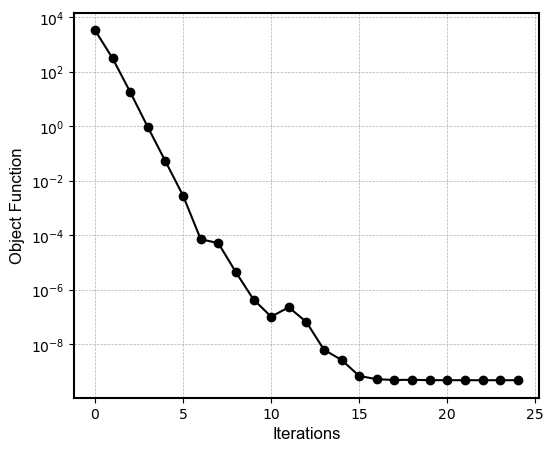

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(obj_list[:-25], "o-", color="k")
ax.set_yscale("log")
ax.set_ylabel("Object Function", fontfamily="Arial", fontsize=12)
ax.set_xlabel("Iterations", fontfamily="Arial", fontsize=12)

ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)

ax.grid(visible=True, axis="both", which="major", linestyle="--", linewidth=0.5)

fig.savefig("Object_curve.png", dpi=600)
fig.savefig("Object_curve.pdf", dpi=600)

In [86]:
def show_disp_curve(result_dict):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    cmap = cm.get_cmap('rainbow')  
    num_lines = len(result_dict)  
    colors = [cmap(i / num_lines) for i in range(num_lines)]
    for item, (label, coeff) in enumerate(result_dict.items()):
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, L=20)
        sigma = linear_sys.cal_sigma(
            v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff
        )

        ax.plot(
            np.linspace(pi / 1000, pi, 1000),
            sigma,
            label=f"{label}",
            color=colors[item]
        )

        ax.set_ylim([0.9, 1.05])
        ax.set_xlim([0, 3.142])
        ax.set_ylabel(
            "$\delta$",
            fontfamily="Arial",
            fontsize=20,
            math_fontfamily="stix",
        )
        ax.set_xlabel("$kh$", fontfamily="Arial", fontsize=20, math_fontfamily="stix")
        ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        ax.set_yticks([0.9, 0.95, 1.0, 1.05])

        ax.grid(visible=True, axis="both", which="major", linestyle="--", linewidth=0.5)

        ax.legend(
            title="",
            fontsize=12,
            loc="lower left",
            borderpad=0.5,
            borderaxespad=1.0,
            labelspacing=0.5,
            edgecolor="black",
            handlelength=2.0,
        )

        ax.spines["left"].set_linewidth(1.5)
        ax.spines["top"].set_linewidth(1.5)
        ax.spines["right"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)

    return fig, ax

/var/folders/zs/zb6k_nkn13q4_6kkxcdv4_g40000gn/T/ipykernel_7420/3439219206.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')
/Volumes/Samsung_T5/My_Research/2_My_Articles/Quantum annealing Seismic forward modeling operator/JGR_MLC论文修改意见/code_for_the_paper/Solution_of_Forward_Operator_v2/core/stagger_FD_coeff.py:70: UserWarning: Max frequency of acoustic wave is not provided! Will take 90% Nyquist frequency.
  warnings.warn(


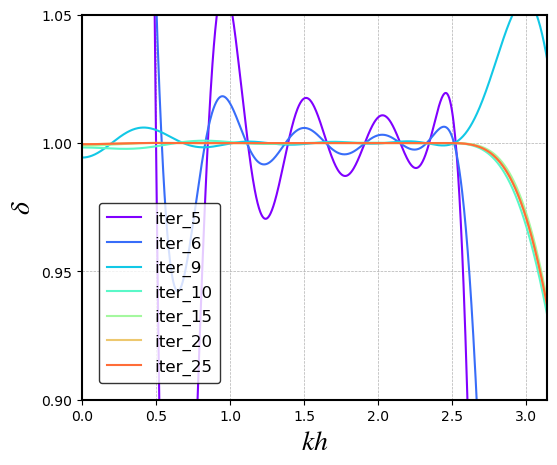

In [87]:
fig, ax = show_disp_curve({k:v for i, (k, v) in enumerate(qa_res_dict.items()) if i in [4, 5, 8, 9, 14, 19, 24]})
fig.savefig("disp_curve.png", dpi=600)
fig.savefig("disp_curve.pdf", dpi=600)